In [1]:
from qiskit import QuantumCircuit, transpile
#from qiskit_aer.primitives import Estimator as local_estimator
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import RZGate
from qiskit.quantum_info import Operator
import numpy as np
import json
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli
import os
import matplotlib.pyplot as plt
import itertools
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix, partial_trace, Operator
import numpy as np

import Create_quantum_circuit
import Manipulate_layers
import time
import local_projection_computation
import Checking_Equivalence_with_Choi

## Now, construct the circuits layer by layer

### Notes on Controlled-Controlled-U Gate Benchmark

- **Gate Placement**:  
  The **CONTROL-CONTROL-U** gate is applied on qubits **(1, 2, 3)** instead of **(0, 1, 2)** in a 20-qubit circuit.

-  **Execution Behavior**:  
  Please run the notebook blocks **in order**. Re-running any block will require **re-execute all steps**.

- **Why Track Choi Local Projections**:  
  We focus on **Choi-based local projections** because the **standard local projection method** does **not capture any changes** in this setup.  
  This is due to the fact that the initial state is `|000...0⟩`, and **control gates leave this state unchanged** unless their control conditions are triggered.

### We prepare gates and their control versions

In [2]:

from scipy.stats import unitary_group

# Generate a Haar-random 4x4 unitary matrix
W = unitary_group.rvs(2)
U = W @ W
print(W)
print(U)


[[ 0.07059362-0.42627525j  0.82319305-0.36831937j]
 [ 0.83563165+0.33915438j -0.08553466-0.42353024j]]
[[ 0.63607617-0.08877442j -0.32529918-0.6940509j ]
 [ 0.27573005-0.71519169j  0.64074161+0.04386323j]]


In [3]:
def construct_control_W(W):
    A_00 = np.array([[1,0],
                     [0,0]])
    A_01 = np.array([[0,1],
                     [0,0]])
    A_10 = np.array([[0,0],
                     [1,0]])
    A_11 = np.array([[0,0],
                     [0,1]])
    # print("A_00 (Top-left block):")
    # print(A_00)
    # print("\nA_01 (Top-right block):")
    # print(A_01)
    # print("\nA_10 (Bottom-left block):")
    # print(A_10)
    # print("\nA_11 (Bottom-right block):")
    # print(A_11)
    control_W = np.kron(A_00,np.eye(2))+np.kron(A_11,W)
    # print(control_W)

    return control_W
np.set_printoptions(linewidth = 200)
# Construct the control version of W
control_W = construct_control_W(W)
print("control_W:")
print(control_W)
# Define the X gate
X = np.array([[0,1],[1,0]])
# Construct the control version of X
control_X = construct_control_W(X)
print("control_X:")
print(control_X)
# Define the SWAP gate
SWAP = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])
print("SWAP gate:")
print(SWAP)

control_W:
[[ 1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.07059362-0.42627525j  0.82319305-0.36831937j]
 [ 0.        +0.j          0.        +0.j          0.83563165+0.33915438j -0.08553466-0.42353024j]]
control_X:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
SWAP gate:
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]


## Embedding the 3-Qubit Circuit into a 20-Qubit Register

In this step, we **place the gates into their designated positions**, effectively **embedding a small 3-qubit circuit** into a **20-qubit quantum circuit**, as described in the paper.

In [4]:
#Deutsch gate circuit
qc_Deutsch = QuantumCircuit(20)
qc_info_Deutsch = []

## Layer 0

[[ 1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.07059362-0.42627525j  0.82319305-0.36831937j]
 [ 0.        +0.j          0.        +0.j          0.83563165+0.33915438j -0.08553466-0.42353024j]]


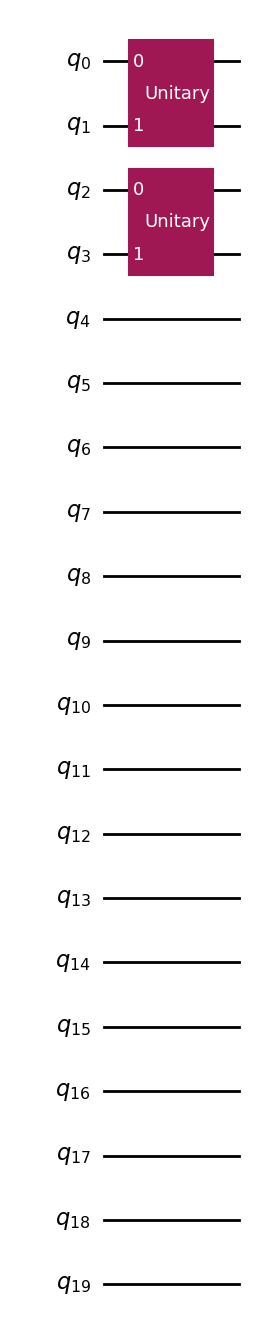

In [5]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[0,1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
qc_info_Deutsch[-1]['layer'] = 0
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2,3],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_W) # control_W is applied on qubits (2,3) instead of (0,1)
qc_info_Deutsch[-1]['layer'] = 0
print(control_W)
qc_Deutsch.draw('mpl')


{'qubits': [2, 3], 'type': 'unitary', 'matrix': [[(1+0j), 0j, 0j, 0j], [0j, (1+0j), 0j, 0j], [0j, 0j, (0.07059361700092581-0.42627524630845454j), (0.8231930493441113-0.3683193711100957j)], [0j, 0j, (0.8356316542123088+0.33915438092672956j), (-0.0855346585073815-0.4235302428052012j)]], 'layer': 0}


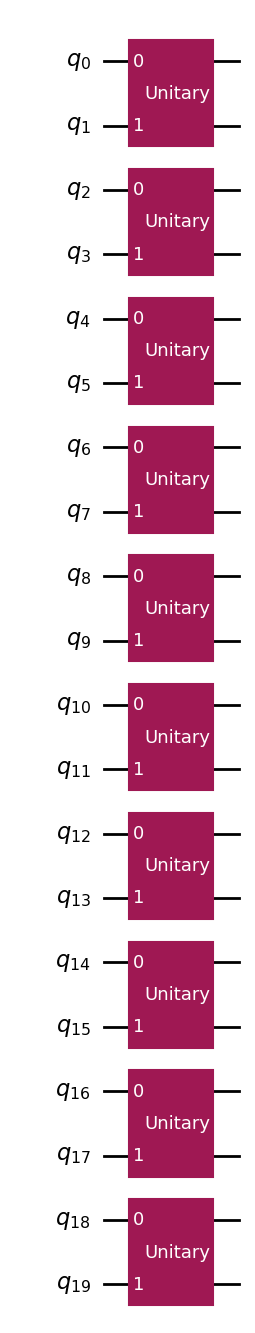

In [6]:
print(qc_info_Deutsch[-1])
for i in range(2,10):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i,2*i+1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))  # other gates are identity gates
    qc_info_Deutsch[-1]['layer'] = 0
qc_Deutsch.draw('mpl')

## Observing Choi-Based Local Projection Changes

In this experiment, we observe the **Choi-based local projection**, which reveals changes that the **standard local projection** does not capture.

The **Choi isomorphism** representation captures the **full behavior of the gate**, not just its action on the specific input state—allowing us to track structural changes more effectively.

---

###  View the Computed Projection

To inspect the resulting local projection, read the file:

In [7]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,1)
np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

### Now, the second layer:

{'qubits': [1, 2], 'type': 'unitary', 'matrix': [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0]], 'layer': 1}


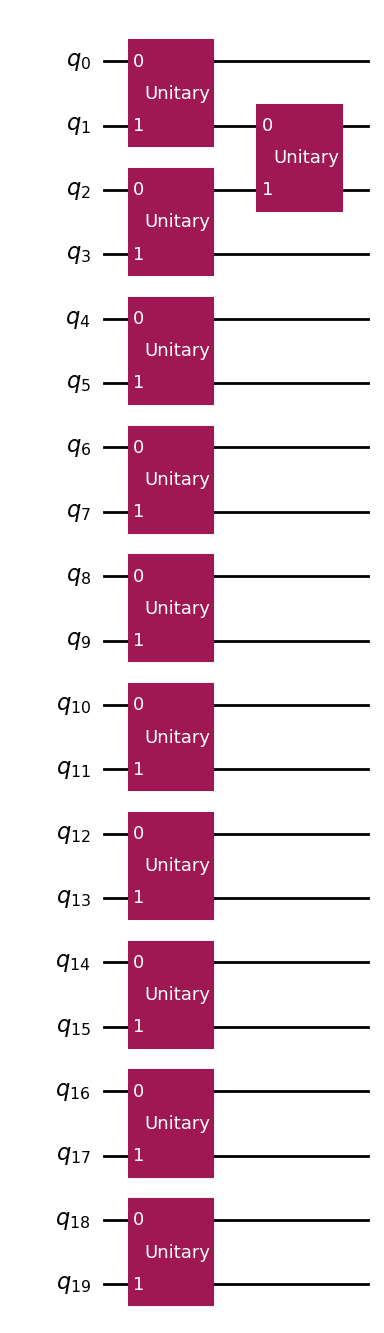

In [8]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[1,2],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_X) # add control_X gate on qubits (1,2)
qc_info_Deutsch[-1]['layer'] = 1
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

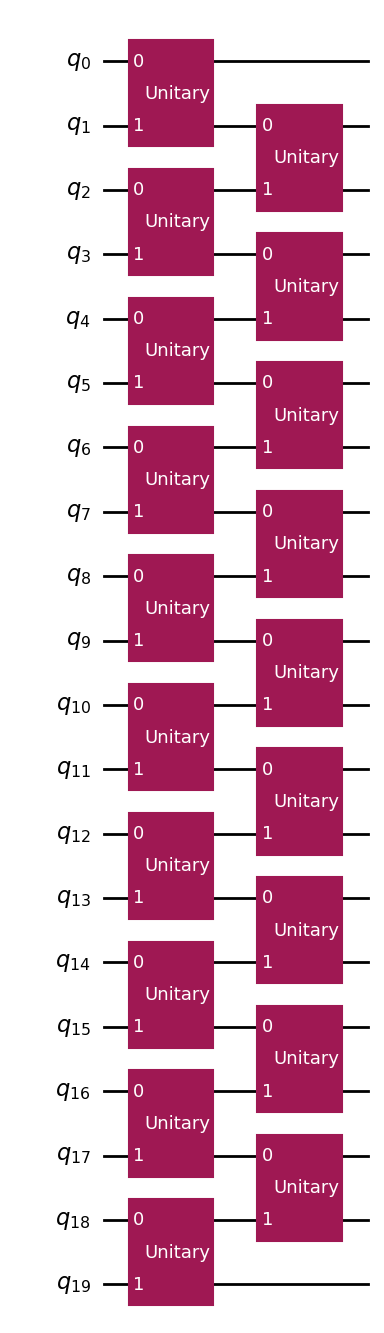

In [9]:
for i in range(1,9):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i+1,2*i+2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))  # other gates are identity gates
    qc_info_Deutsch[-1]['layer'] = 1
qc_Deutsch.draw('mpl')

## Compute Choi local projection

In [10]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,2)
np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

## Now, layer 2

{'qubits': [2, 3], 'type': 'unitary', 'matrix': [[(1-0j), -0j, -0j, -0j], [-0j, (1-0j), -0j, -0j], [-0j, -0j, (0.07059361700092581+0.42627524630845454j), (0.8356316542123088-0.33915438092672956j)], [-0j, -0j, (0.8231930493441113+0.3683193711100957j), (-0.0855346585073815+0.4235302428052012j)]], 'layer': 2}


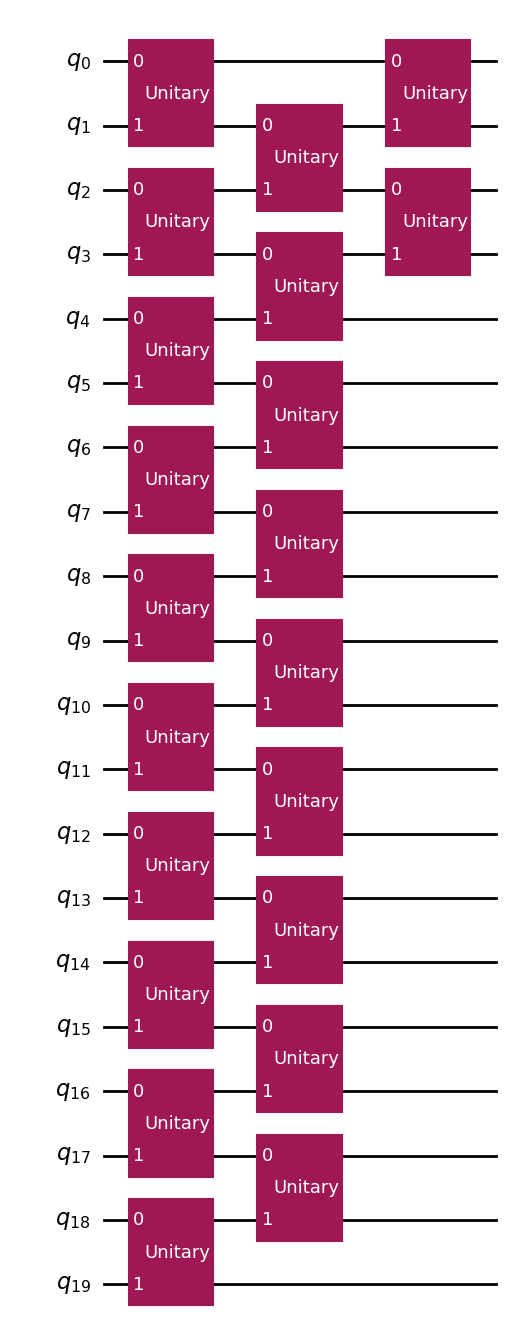

In [11]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[0,1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))     # add identity gate on qubits (0,1)
qc_info_Deutsch[-1]['layer'] = 2
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2,3],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.transpose(np.conjugate(control_W))) # control_W is applied on qubits (2,3)
qc_info_Deutsch[-1]['layer'] = 2
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

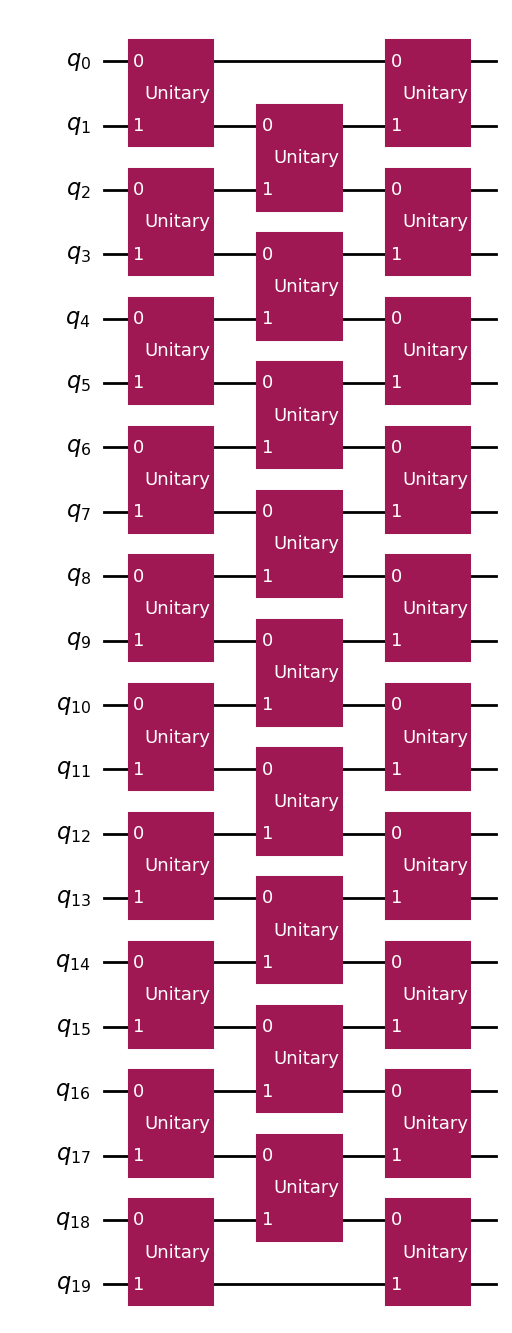

In [12]:
for i in range(2,10):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i,2*i+1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4)) # other gates are identity gates
    qc_info_Deutsch[-1]['layer'] = 2
qc_Deutsch.draw('mpl')

## Now, it is harder to see the positions where the numbers are not 0.5 or 0 in the Choi local projection, but they are somewhere in the middle of the large matrix

In [13]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,3)
np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

## Layer 3

{'qubits': [1, 2], 'type': 'unitary', 'matrix': [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]], 'layer': 3}


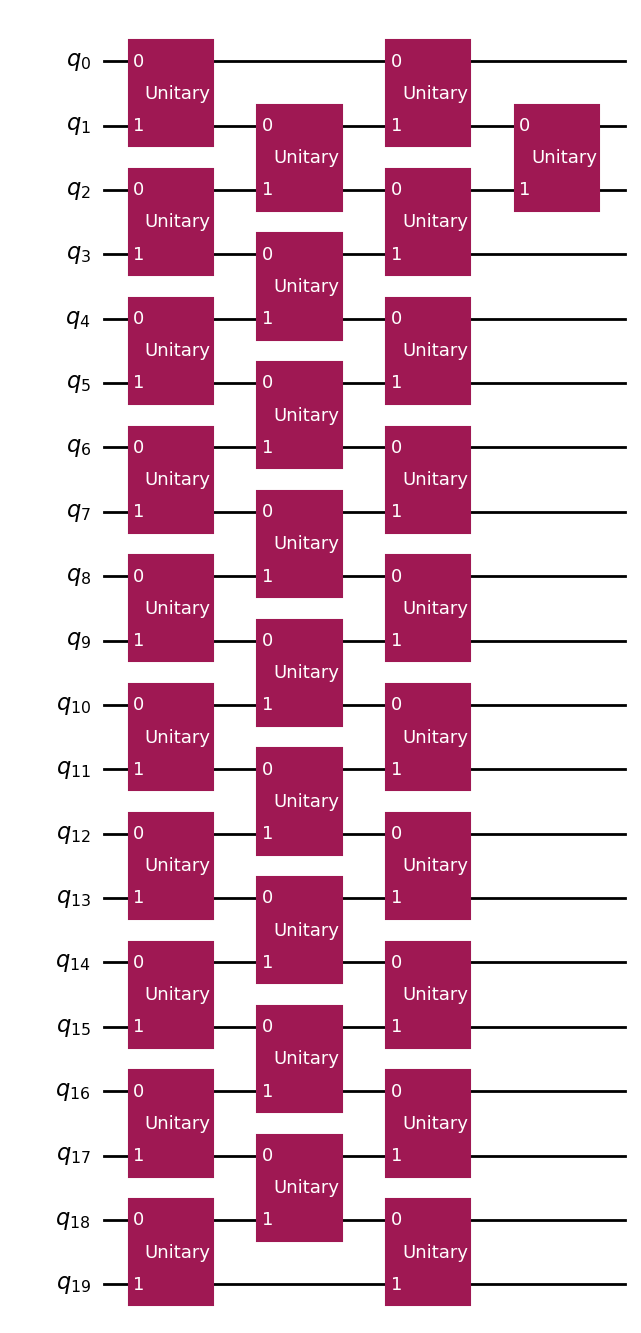

In [14]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[1,2],qc_info_Deutsch,qc_Deutsch,gate_matrix=SWAP@control_X) # add control_X and SWAP gate on qubits (1,2)
qc_info_Deutsch[-1]['layer'] = 3
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

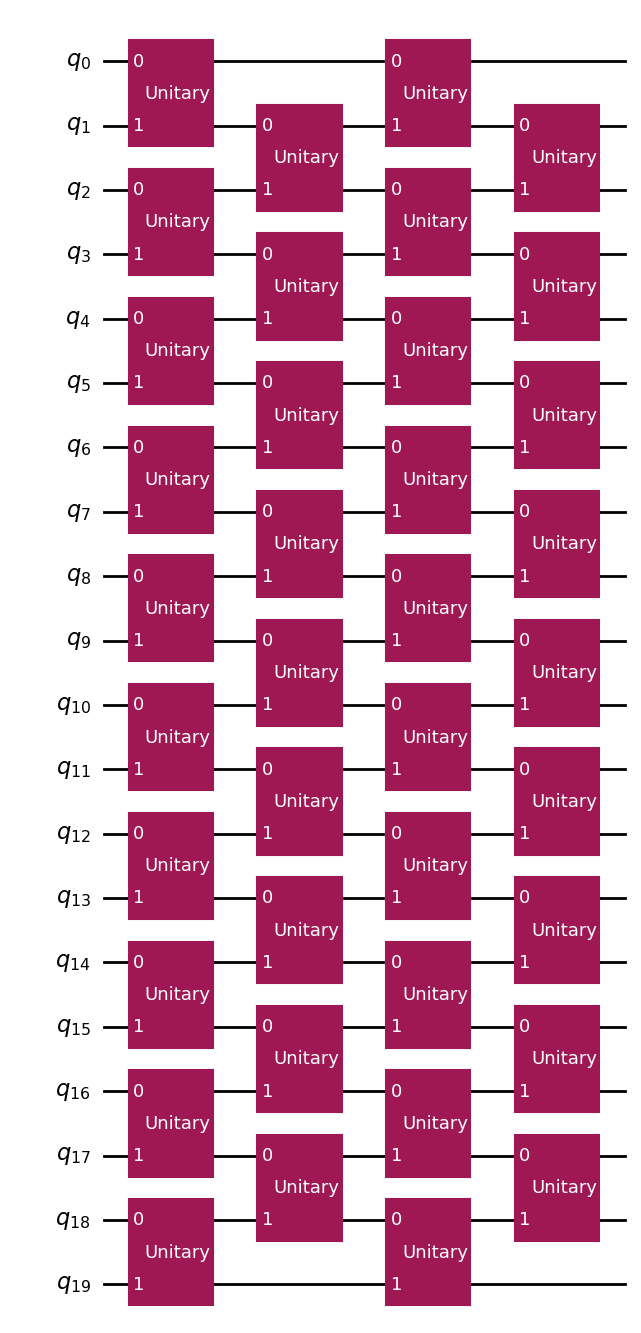

In [15]:
for i in range(1,9):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i+1,2*i+2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
    qc_info_Deutsch[-1]['layer'] = 3
qc_Deutsch.draw('mpl')

In [16]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,4)
np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

## Layer 4

{'qubits': [2, 3], 'type': 'unitary', 'matrix': [[(1+0j), 0j, 0j, 0j], [0j, (1+0j), 0j, 0j], [0j, 0j, (0.07059361700092581-0.42627524630845454j), (0.8231930493441113-0.3683193711100957j)], [0j, 0j, (0.8356316542123088+0.33915438092672956j), (-0.0855346585073815-0.4235302428052012j)]], 'layer': 4}


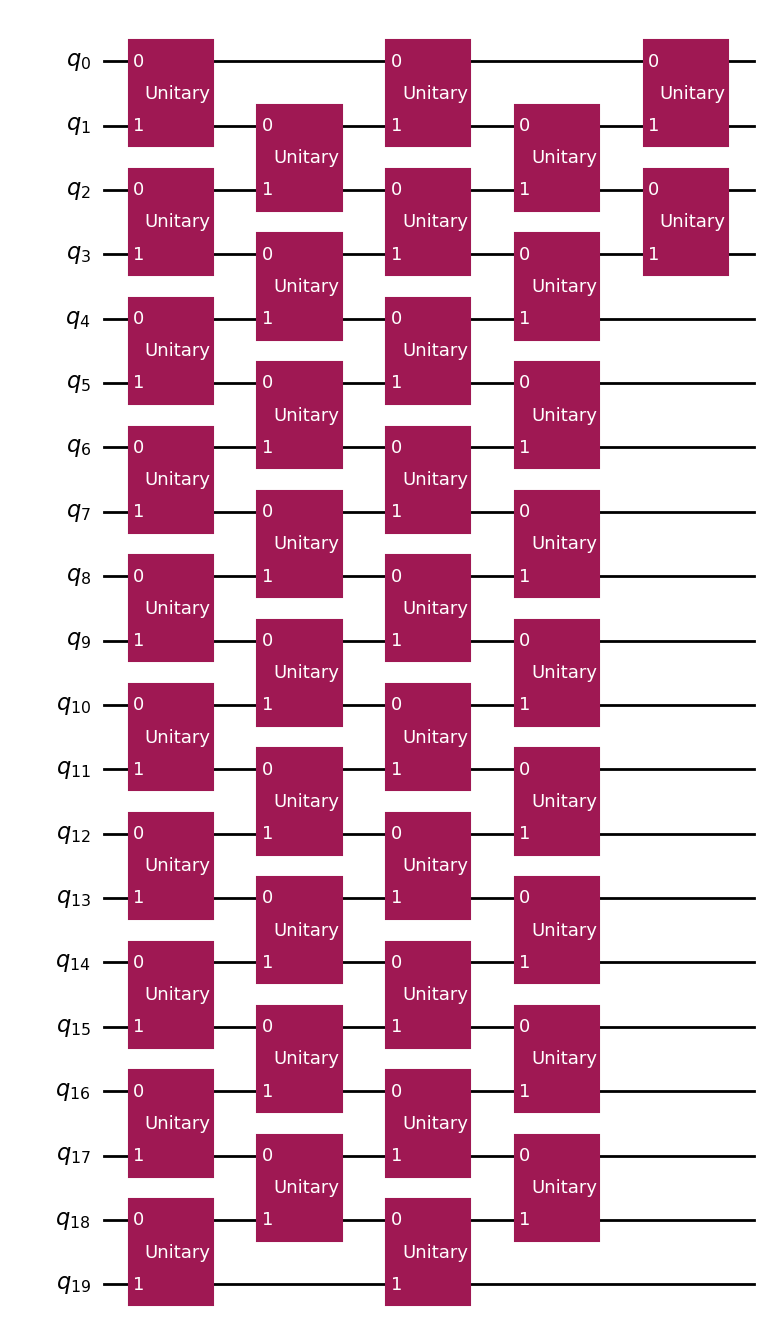

In [17]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[0,1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
qc_info_Deutsch[-1]['layer'] = 4
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2,3],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_W)
qc_info_Deutsch[-1]['layer'] = 4
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

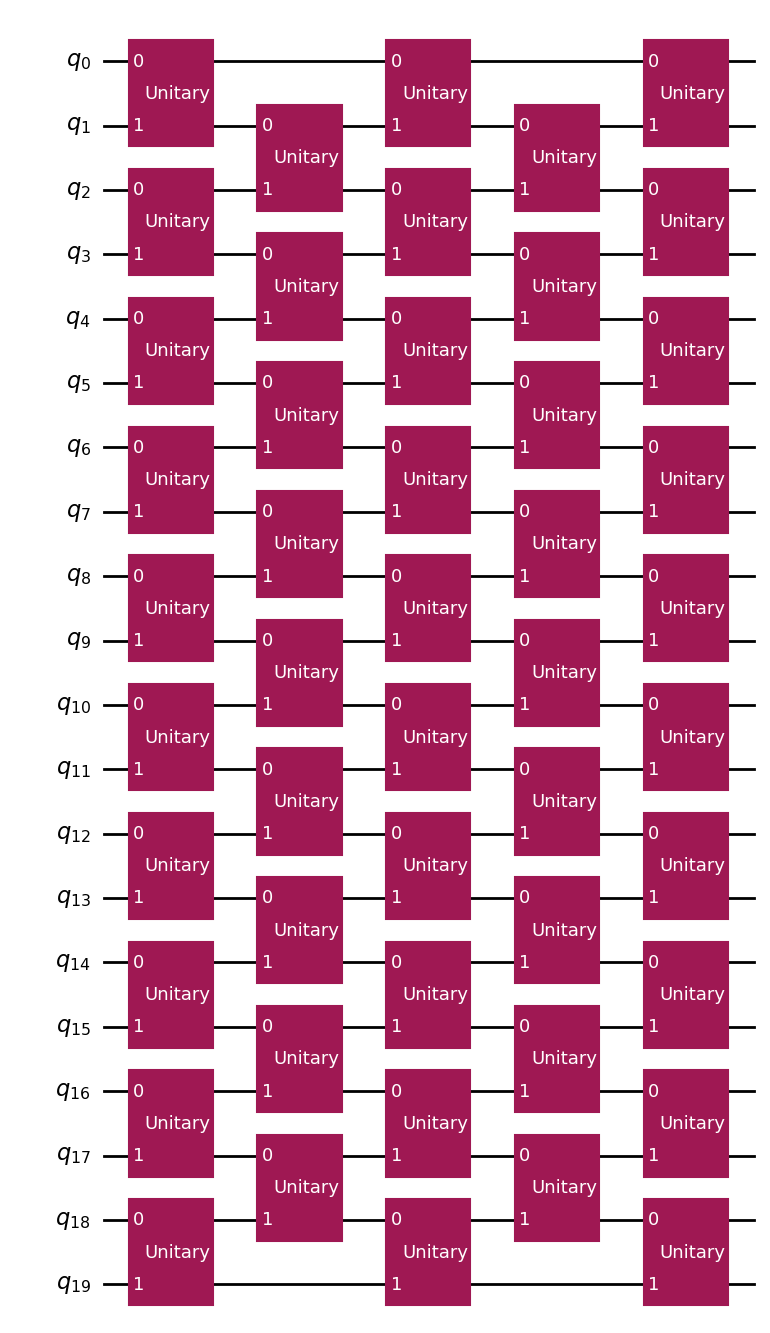

In [18]:
for i in range(2,10):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i,2*i+1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
    qc_info_Deutsch[-1]['layer'] = 4
qc_Deutsch.draw('mpl')

In [19]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,5)
np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

## Layer 5

{'qubits': [1, 2], 'type': 'unitary', 'matrix': [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], 'layer': 5}


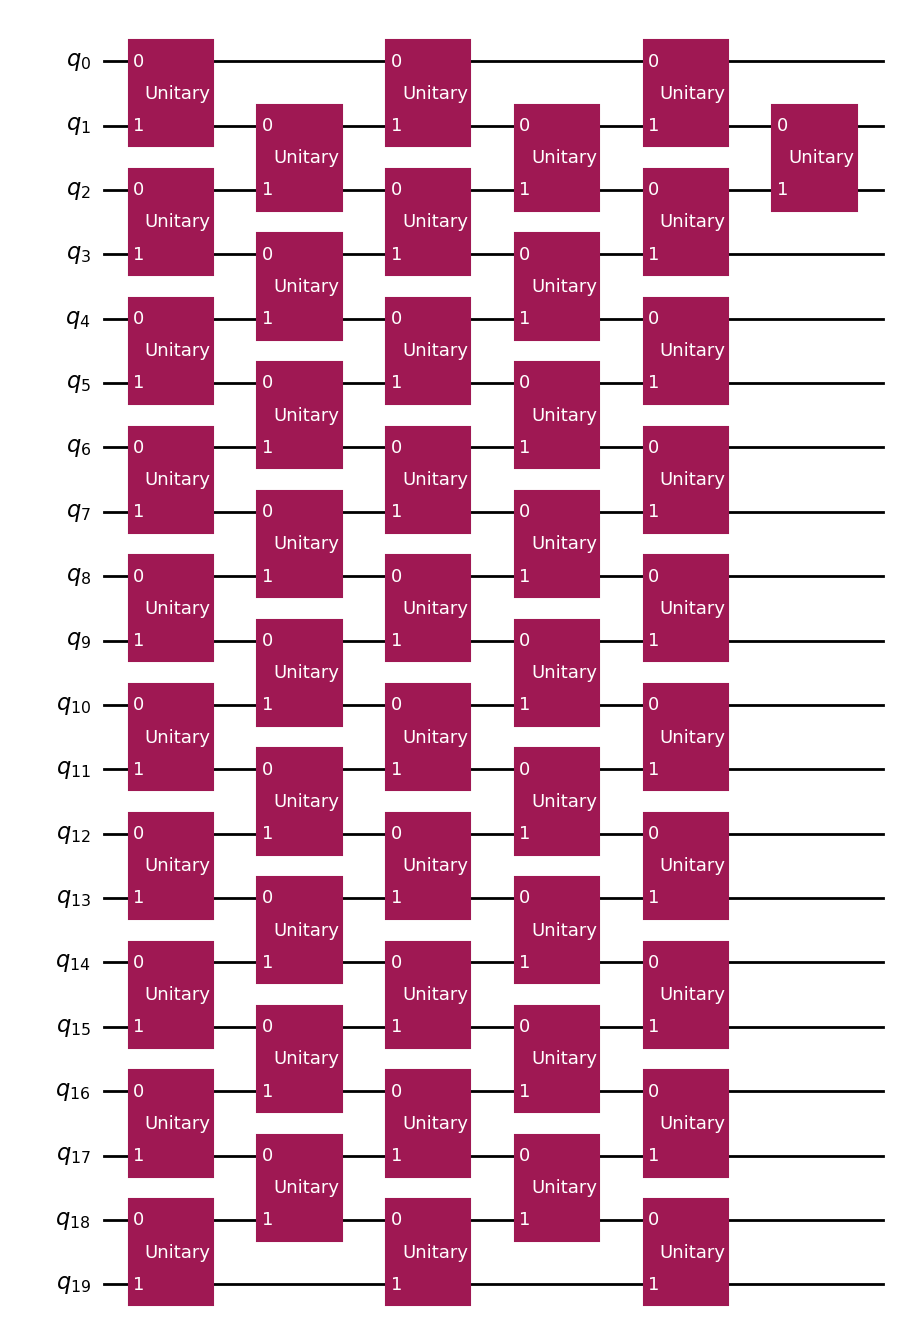

In [20]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[1,2],qc_info_Deutsch,qc_Deutsch,gate_matrix=SWAP)
qc_info_Deutsch[-1]['layer'] = 5
print(qc_info_Deutsch[-1])#################
qc_Deutsch.draw('mpl')

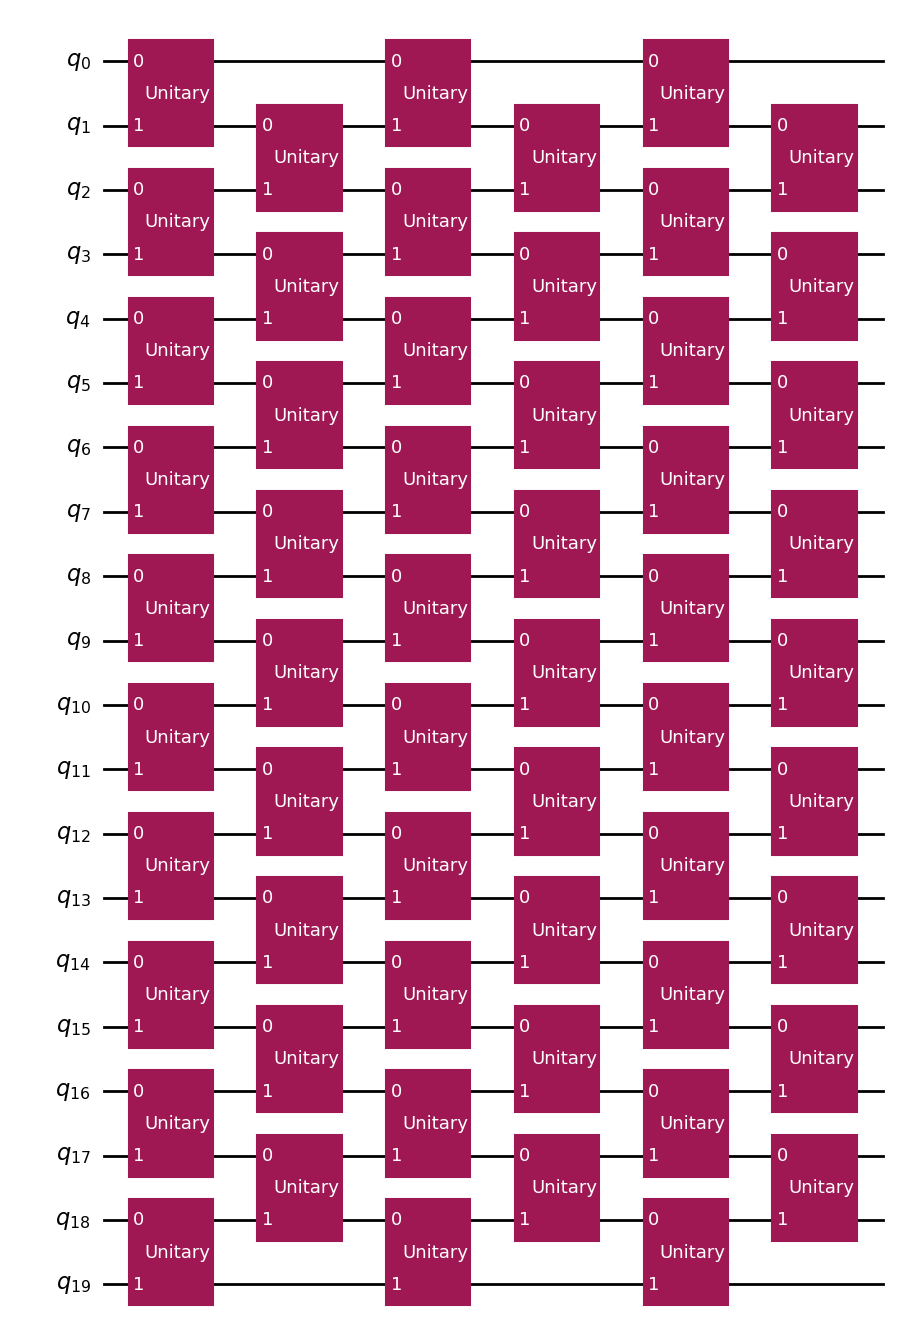

In [21]:
for i in range(1,9):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i+1,2*i+2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
    qc_info_Deutsch[-1]['layer'] = 5
qc_Deutsch.draw('mpl')


## Running time can be siginificantly longer due to the printing of the matrix to txt file

In [22]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,6)
# np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

## Last layer, layer 6   (7th layer)
### First, prepare the control-control-U's inverse gate

In [23]:
A_00 = np.array([[1,0],
                     [0,0]])
A_01 = np.array([[0,1],
                     [0,0]])
A_10 = np.array([[0,0],
                     [1,0]])
A_11 = np.array([[0,0],
                     [0,1]])
toffoli = np.kron(A_00,np.eye(4))+np.kron(A_11,control_X) 
print(toffoli)          # Toffoli gate is printed here to check the corretness of the control-control gate construction
print(U)
control_control_U_inverse = np.kron(A_00,np.eye(4))+np.kron(A_11,np.transpose(np.conjugate(control_W@control_W)))     
print(control_control_U_inverse)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
[[ 0.63607617-0.08877442j -0.32529918-0.6940509j ]
 [ 0.27573005-0.71519169j  0.64074161+0.04386323j]]
[[ 1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          1.        +0.j      

{'qubits': [1, 2, 3], 'type': 'unitary', 'matrix': [[(1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j], [0j, (1+0j), 0j, 0j, 0j, 0j, 0j, 0j], [0j, 0j, (1+0j), 0j, 0j, 0j, 0j, 0j], [0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j], [0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j], [0j, 0j, 0j, 0j, 0j, 0j, (0.6360761709976012+0.08877441927542642j), (0.2757300473387842+0.7151916863092669j)], [0j, 0j, 0j, 0j, 0j, 0j, (-0.3252991848343252+0.6940508969214467j), (0.6407416090870031-0.043863233046104844j)]], 'layer': 6}


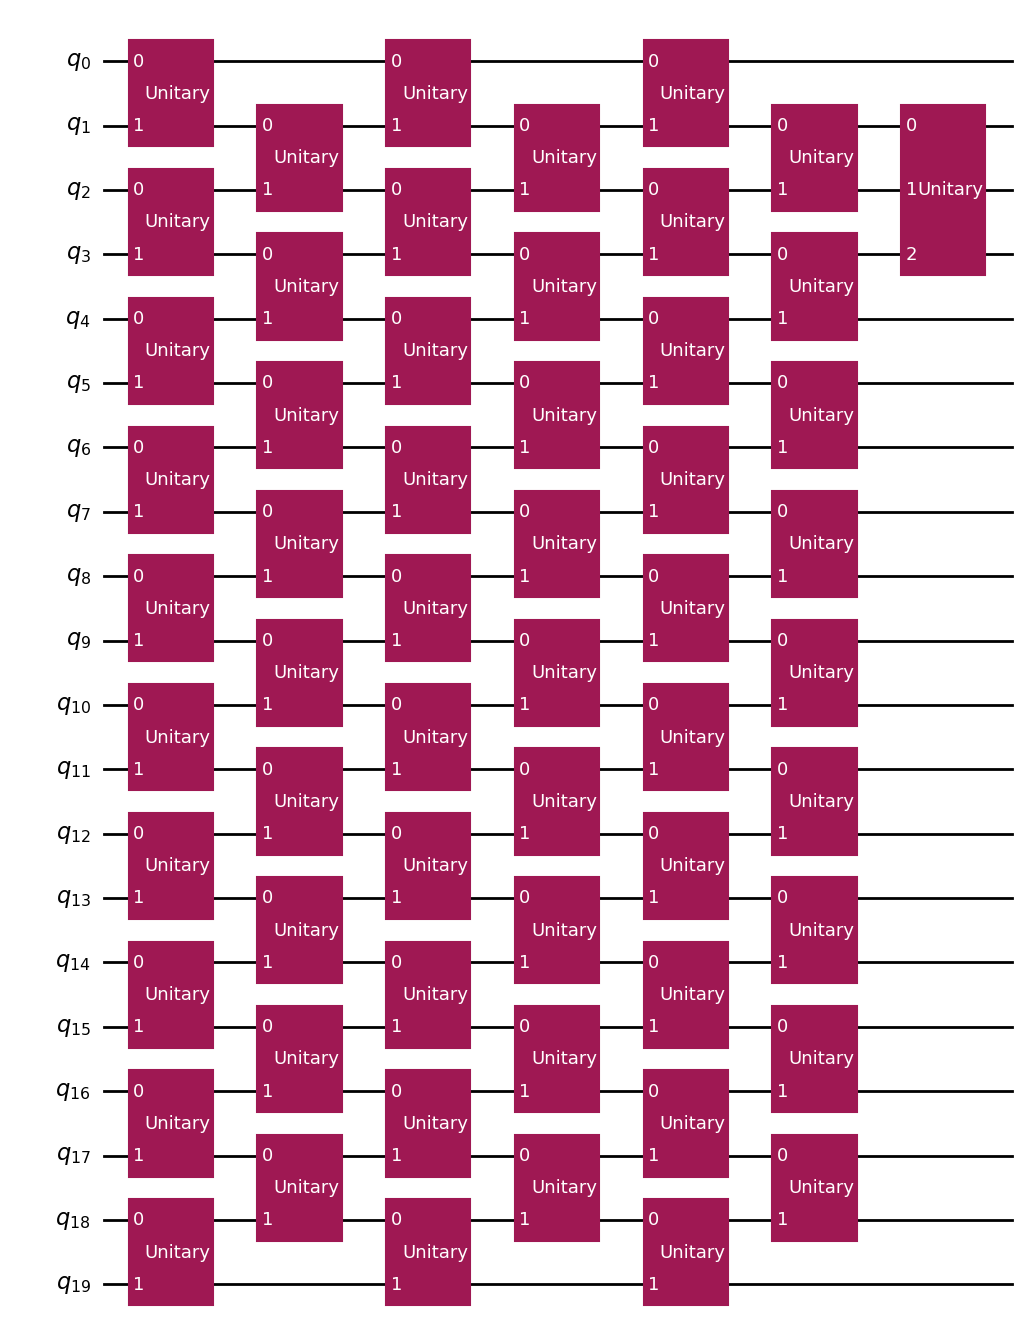

In [24]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[1,2,3],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_control_U_inverse)
qc_info_Deutsch[-1]['layer'] = 6
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

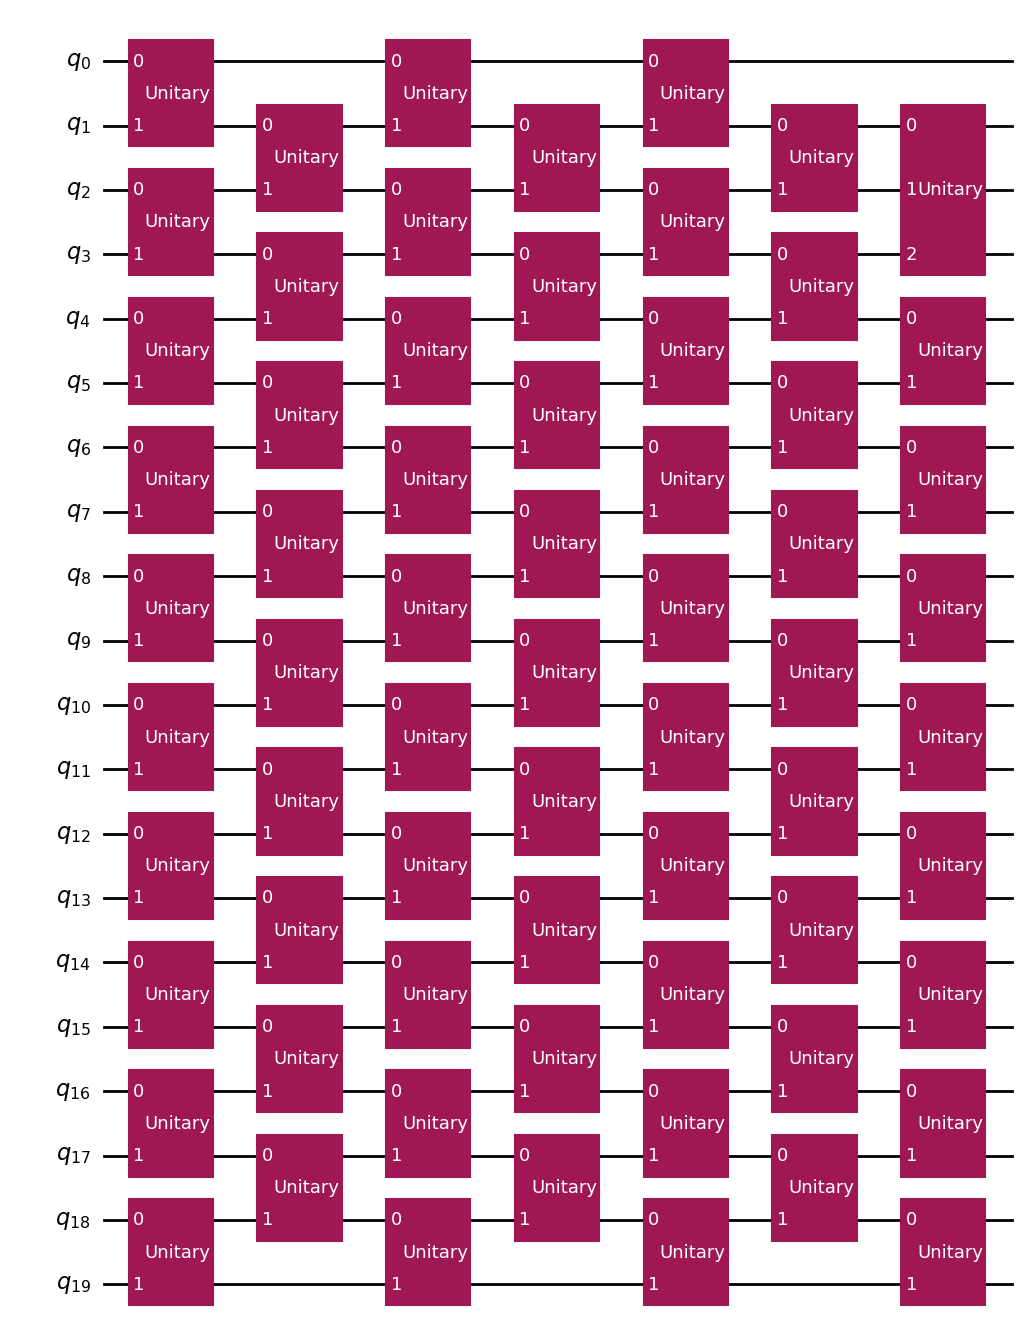

In [25]:
for i in range(2,10):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i,2*i+1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
    qc_info_Deutsch[-1]['layer'] = 6
qc_Deutsch.draw('mpl')

### The following function is used to compute Choi local projection

In [26]:
def compute_local_projections_with_Choi_isomorphism_efficient(gates_info, n_qubits, depth, given_dictionary=None,yes_print=None):
    """
    Updates the local projections in the local_projection_dict based on gates_layers.

    Arguments:
    - gates_info (list): List of gate information for the circuit, where each gate includes its matrix.
    - local_projection_dict (list): The local projection dictionary initialized earlier.
    - n_qubits (int): The total number of qubits in the circuit.
    - depth (int): The expected number of layers in the circuit.

    Returns:
    - list: The updated local_projection_dict with updated local projections.
    """
    
    if depth == 0:
        return False

    ###### We now treat qubits as qudits of dimension 4


    # Divide the gates into layers and check the calculated depth against the expected depth.
    gates_layers, depth_check = Manipulate_layers.divide_circuit_into_layers_using_layer_index(gates_info)

    if given_dictionary == None:

        initial_dict = local_projection_computation.initialize_local_projection_dict(gates_layers,n_qubits)
        # print(initial_dict)
        dict_previous = [entry for entry in initial_dict if entry['layer'] == 0]
        for entry in dict_previous:
            layer = entry['layer']  # Extract the current layer from the entry.
            initial_qubit_entry = entry['initial_qubit']
            qubit_indices = entry['qubit_indices']  # Get the qubit indices for this entry.
            if yes_print == True:
                print('computing local projection for initial qubit:',initial_qubit_entry, ' involved:', qubit_indices)
            if layer == 0:
                # For layer 0, we need to update the local projection using the associated unitary matrix.
                U_index = None  # Initialize U_index to None before searching
                for gate in gates_layers[layer]:
                    # Check if the current gate's qubits match the qubit indices for layer 0.
                    if qubit_indices == gate['qubits']:
                        U_index = np.kron(np.eye(2),np.array(gate['matrix'], dtype=np.complex128))   # Get the unitary matrix for this gate.

                if U_index is None:
                    print("No matching gate found for layer 0 and qubit indices:", qubit_indices)
                    return False  # Handle the case where no gate is found
                EPR_vector = 1/np.sqrt(2) * np.array([1, 0, 0, 1], dtype=np.complex128)
                EPR_projector_AB = 1/2 * np.array([[1, 0, 0, 1], [0, 0, 0, 0],[0, 0, 0, 0],[1, 0, 0, 1]], dtype=np.complex128)
                if initial_qubit_entry == qubit_indices[0]:
                    A_00 = np.array([[1,0],[0,0]])
                    EPR_projector = np.kron(EPR_projector_AB, np.eye(2)) 
                else:
                    EPR_projector = Checking_Equivalence_with_Choi.reconstruct_matrix_M_ACB(EPR_projector_AB,np.eye(2))
                # print(EPR2)

                # Update the local projection using the unitary matrix and a measurement projection.
                entry['local_projection'] = U_index @ EPR_projector @ U_index.conj().T
                # print(entry['local_projection'].shape)
                
    else:
        initial_dict = local_projection_computation.initialize_local_projection_with_initial_dict(gates_info, given_dictionary)  
        # print(initial_dict)
    # Sort the local projection dictionary by layer to ensure correct processing order.
    # initial_dict.sort(key=lambda x: x['layer'])


    if depth_check != depth:
        return False  # Return False if the depths do not match, indicating an inconsistency.
        
    if depth == 0:
        return given_dictionary
    

    # Process each entry in the sorted local projection dictionary.
    for layer_check in range(depth):
        # print(layer_check)
        if layer_check == 0:
            if given_dictionary == None:
                continue  
            else:
                dict_previous = [e for e in initial_dict if e['layer']==0]
            # print(dict_previous)
                
        # else:
        #     print('layer = ', layer_check)
        
        dict_current = [entry for entry in initial_dict if entry['layer'] == layer_check]
        
        for entry in dict_current:
            layer = entry['layer']  # Extract the current layer from the entry.
            initial_qubit_entry = entry['initial_qubit']
            qubit_indices = entry['qubit_indices']  # Get the qubit indices for this entry.

            # For layers k > 0, we need to perform additional checks and updates.
            previous_layer_entry = next(
                (e for e in dict_previous if e['initial_qubit'] == initial_qubit_entry),
                None
            )
            if yes_print == True:
                print('computing local projection for initial qubit:',initial_qubit_entry, ' involved:', qubit_indices)
            # If there's a previous layer entry, we need to update the projection.
            if previous_layer_entry:
                previous_projection = previous_layer_entry['local_projection']  # Get the previous local projection.
                # print('ssss',previous_projection.shape)
                # Determine any additional qubits that are present in the current layer but not in the previous layer.
                additional_qubits_previous = set(qubit_indices) - set(previous_layer_entry['qubit_indices'])
                # print(additional_qubits_previous)
                for index in additional_qubits_previous:
                    # Adjust the previous projection for new qubits added.
                    if index < previous_layer_entry['qubit_indices'][0]:
                        previous_projection = Checking_Equivalence_with_Choi.reconstruct_matrix_M_ACB(previous_projection,np.eye(2))  # Add identity for leftmost qubit.
                    elif index > previous_layer_entry['qubit_indices'][-1]:
                        previous_projection = np.kron(previous_projection, np.eye(2))  # Add identity for rightmost qubit.
                    else:
                        # If the additional qubit is not at the end, there is a contradiction.
                        print('contradiction 1')
                        return False
            
            # Initialize matrix for the current layer's projection.
            matrix = np.eye(1, dtype=np.complex128)  # Start with the identity matrix for tensor products.
            qubit_count = []  # List to keep track of qubit counts involved in the current layer's gates.

            # Check the gates in the current layer to build the current projection.
            for gate_info in gates_layers[layer]:
                involved_qubits = gate_info['qubits']  # Get the qubits involved in the current gate.
                # print(involved_qubits)
                # print("checkkkkkkkkk")
                # If any of the involved qubits intersect with the current qubit_indices, update the matrix.
                if set(involved_qubits).intersection(set(qubit_indices)):
                    # print(involved_qubits)
                    unitary_matrix = (np.array(gate_info['matrix'], dtype=np.complex128))  # Get the unitary matrix.
                    matrix = np.kron(matrix, unitary_matrix)  # Update the matrix with the unitary for this gate.
                    qubit_count=qubit_count+involved_qubits
                    # qubit_count.append(involved_qubits[0])  # Track the first qubit.
                    # qubit_count.append(involved_qubits[1])  # Track the second qubit.
            # print(matrix.shape)
            # print(qubit_count)

            # Check if qubit_count is a sequential natural number array.
            if not local_projection_computation.is_sequential_natural_numbers(qubit_count):
                print('contradiction 2')
                return False  # Return False for non-sequential qubit indices.

            # Handle additional qubits not included in the current layer's unitary operations.
            additional_qubits_next = set(qubit_indices) - set(qubit_count)  # Find qubits that need identities.
            # print(qubit_indices, additional_qubits_next,qubit_count)
            for index in additional_qubits_next:
                if len(additional_qubits_next) > 1:
                    print('contradiction 3')  # More than one additional qubit is a contradiction.
                    return False
                elif index < qubit_count[0]:
                    # print("top")
                    matrix = np.kron(np.eye(2), matrix)  # Add identity to the left for new qubits.
                    # print('yyy',matrix.shape)
                elif index > qubit_count[-1]:
                    # print('bottom')
                    matrix = np.kron(matrix, np.eye(2))  # Add identity to the right for new qubits.
                else:
                    print('contradiction 4')  # Found a contradiction if the index is not in expected order.
                    return False
            matrix = np.kron(np.eye(2),matrix)
            
            # print('xxx',matrix.shape)
            # print(previous_projection.shape)

            # Finally, update the local projection for the current entry.
            current_local_projection = matrix @ previous_projection @ matrix.conj().T
            entry['local_projection'] = current_local_projection  # Store the updated projection matrix.
        
        dict_previous = dict_current  # Update dict_previous for the next layer check.

    return dict_previous  # Return the updated local projection dictionary.

## We check weak equivalence with normal local projection

In [27]:
local_projection = local_projection_computation.compute_local_projections_fullly_general(qc_info_Deutsch,n_qubits=20,depth = 7)


In [28]:
check = True
count = 0
tolerance = 1e-15  # Define a tolerance for numerical comparisons
for entry in (local_projection):
    local_proj = entry['local_projection']
    # print(local_proj)
    count += 1
    # print(count)
    # Create the target eigenvector
    target_eigenvector = np.zeros(local_proj.shape[0], dtype=np.complex128)
    target_eigenvector[0] = 1  # (1, 0, 0, ..., 0)
    projection_result = local_proj @ target_eigenvector
    # print("projection_result:",projection_result)
    if np.linalg.norm(projection_result-target_eigenvector,ord=1)>local_proj.shape[0]*tolerance:
        check = False
        break

# If all checks pass
if check == True:
    print("All local_projections in local_projection_2 have (1, 0, 0, ..., 0) as an eigenvector with eigenvalue 1.")
    print("Number of entries in local_projection:", count)
    print("Checking successfull.")   
else:
    print("Not all local projections are correct.")
    print("Number of entries in local_projection:", count)
    print("Checking failed.")

All local_projections in local_projection_2 have (1, 0, 0, ..., 0) as an eigenvector with eigenvalue 1.
Number of entries in local_projection: 10
Checking successfull.


### We check equivalence with Choi local projection:  This part take around 120 minutes. One can run the file `micro_benchmark_FIG_3.py` to cover this part under tmux by two lines:
bash:

tmux new -s run

python3 micro_benchmark_FIG_3.py

### Then check the result using:
bash:

tmux attach -t run

In [ ]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,7)
# np.savetxt("large_matrix.txt", Choi_local_projection[1]['local_projection'], fmt="%.3f")

In [ ]:
# Choi_isomorphism_projection = local_projection_computation.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,7)
import numpy as np
# Assuming `find_position_of_initial_qubit_in_entry` and `reconstruct_matrix_M_ACB` are already defined
tolerance = 1e-15  # Define a tolerance for numerical comparisons
EPR_projector_AB = 1/2 * np.array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]], dtype=np.complex128)
count =0
check = True
for entry in Choi_local_projection:
    print(entry["qubit_indices"])
    print(entry['initial_qubit'])
    count+=1
    structure = Checking_Equivalence_with_Choi.find_position_of_initial_qubit_in_entry(entry)
    print(structure)  # Get the positions before and after the qubit
    test_density_matrix = EPR_projector_AB
    
    # Reconstruct the matrix based on the structure
    test_density_matrix = Checking_Equivalence_with_Choi.reconstruct_matrix_M_ACB(EPR_projector_AB, np.eye(2**structure[0]))
    test_density_matrix = np.kron(test_density_matrix, np.eye(2**structure[1]))
    # print(test_density_matrix)
    # Compute the image after applying the local projection
    image = test_density_matrix @ test_density_matrix
    
    # Compare the resulting matrix with the original test_density_matrix
    if np.linalg.norm(image-test_density_matrix,ord=1)>image.shape[0]*tolerance:
        check = False
        break

# If all checks pass    
if check == True:
    print("Number of entries in Choi_local_projection:", count)
    print("All local projections are correct.")
    print("Checking successfull.")
else:
    print("Not all local projections are correct.")
    print("Number of entries in Choi_local_projection:", count)
    print("Checking failed.")

NameError: name 'Choi_local_projection' is not defined

In [ ]:
# local_projection = compute_local_projections_fullly_general(qc_info_Deutsch,4,7)